In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os

print('Libraries loaded successfully')

Libraries loaded successfully


In [14]:
# Download from Kaggle or load preprocessed data
current_path = None
if not current_path:
    path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

    # Load datasets
    gdsc_dataset = pd.read_csv(os.path.join(path, 'GDSC_DATASET.csv'))
    compounds_annotation = pd.read_csv(os.path.join(path, 'Compounds-annotation.csv'))
    gdsc2_dataset = pd.read_csv(os.path.join(path, 'GDSC2-dataset.csv'))
    cell_lines_details = pd.read_excel(os.path.join(path, 'Cell_Lines_Details.xlsx'))

print("Path to dataset files:", path)

Path to dataset files: /Users/laihongsheng/.cache/kagglehub/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc/versions/2


/Users/laihongsheng/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [ ]:
## See files
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['GDSC_DATASET.csv', 'Compounds-annotation.csv', 'GDSC2-dataset.csv', 'Cell_Lines_Details.xlsx']


In [8]:
# show shapes adn columns of the datasets
print("GDSC dataset shape:", gdsc_dataset.shape)
print("GDSC dataset columns:", gdsc_dataset.columns)
print("Compounds annotation shape:", compounds_annotation.shape)
print("Compounds annotation columns:", compounds_annotation.columns)
print("GDSC2 dataset shape:", gdsc2_dataset.shape)
print("GDSC2 dataset columns:", gdsc2_dataset.columns)
print("Cell lines details shape:", cell_lines_details.shape)
print("Cell lines details columns:", cell_lines_details.columns)


GDSC dataset shape: (242035, 19)
GDSC dataset columns: Index(['COSMIC_ID', 'CELL_LINE_NAME', 'TCGA_DESC', 'DRUG_ID', 'DRUG_NAME',
       'LN_IC50', 'AUC', 'Z_SCORE', 'GDSC Tissue descriptor 1',
       'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
       'Microsatellite instability Status (MSI)', 'Screen Medium',
       'Growth Properties', 'CNA', 'Gene Expression', 'Methylation', 'TARGET',
       'TARGET_PATHWAY'],
      dtype='object')
Compounds annotation shape: (621, 6)
Compounds annotation columns: Index(['DRUG_ID', 'SCREENING_SITE', 'DRUG_NAME', 'SYNONYMS', 'TARGET',
       'TARGET_PATHWAY'],
      dtype='object')
GDSC2 dataset shape: (242036, 19)
GDSC2 dataset columns: Index(['DATASET', 'NLME_RESULT_ID', 'NLME_CURVE_ID', 'COSMIC_ID',
       'CELL_LINE_NAME', 'SANGER_MODEL_ID', 'TCGA_DESC', 'DRUG_ID',
       'DRUG_NAME', 'PUTATIVE_TARGET', 'PATHWAY_NAME', 'COMPANY_ID',
       'WEBRELEASE', 'MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE',
       'Z_SCORE'],
    

## Data Cleaning and Preprocessing: All datasets

In [ ]:
# Merge GDSC2 dataset with Cell Lines Details on COSMIC_ID
merged_df = pd.merge(gdsc2_dataset, cell_lines_details, left_on='COSMIC_ID', right_on='COSMIC identifier', how='left')

# Merge the resulting dataframe with Compounds Annotation on DRUG_ID
merged_df = pd.merge(merged_df, compounds_annotation, on='DRUG_ID', how='left')

# Drop NA values
merged_df = merged_df.dropna()

In [36]:
merged_df.shape, merged_df.columns

((166644, 19),
 Index(['COSMIC_ID', 'CELL_LINE_NAME', 'TCGA_DESC', 'DRUG_ID', 'DRUG_NAME',
        'LN_IC50', 'AUC', 'Z_SCORE', 'GDSC Tissue descriptor 1',
        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)',
        'Microsatellite instability Status (MSI)', 'Screen Medium',
        'Growth Properties', 'CNA', 'Gene Expression', 'Methylation', 'TARGET',
        'TARGET_PATHWAY'],
       dtype='object'))

In [37]:
# Find the data types in each column
data_types = merged_df.dtypes
print("Data types of each column:")
print(data_types)

Data types of each column:
COSMIC_ID                                    int64
CELL_LINE_NAME                              object
TCGA_DESC                                   object
DRUG_ID                                      int64
DRUG_NAME                                   object
LN_IC50                                    float64
AUC                                        float64
Z_SCORE                                    float64
GDSC Tissue descriptor 1                    object
GDSC Tissue descriptor 2                    object
Cancer Type (matching TCGA label)           object
Microsatellite instability Status (MSI)     object
Screen Medium                               object
Growth Properties                           object
CNA                                         object
Gene Expression                             object
Methylation                                 object
TARGET                                      object
TARGET_PATHWAY                              object
dtyp

In [38]:
# One-hot encoding categorical features with low cardinality and frequency encoding for high cardinality features
def encode_categorical_features(df, threshold=10):
    # Identify all categorical columns (type 'object')
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    
    # List for storing names based on cardinality
    low_card_cols = []
    high_card_cols = []
    
    # Separate columns based on the number of unique values
    for col in cat_cols:
        unique_count = df[col].nunique()
        if unique_count <= threshold:
            low_card_cols.append(col)
        else:
            high_card_cols.append(col)
    
    print("Low cardinality columns:", low_card_cols)
    print("High cardinality columns:", high_card_cols)
    
    # One-hot encode low-cardinality features
    df_onehot = pd.get_dummies(df[low_card_cols], drop_first=True)
    
    # Frequency encode high-cardinality features
    df_freq = pd.DataFrame(index=df.index)
    for col in high_card_cols:
        # Compute frequencies (as proportion)
        freq_enc = df[col].value_counts(normalize=True)
        df_freq[f"{col}_freq_enc"] = df[col].map(freq_enc)
    
    # Drop the original categorical columns from the dataframe
    df = df.drop(columns=cat_cols)
    
    # Concatenate the numeric part with the new encoded categorical features
    df_encoded = pd.concat([df, df_onehot, df_freq], axis=1)
    return df_encoded

# Example usage:
# Suppose df is your DataFrame.
threshold = 50
df_encoded = encode_categorical_features(merged_df, threshold)


Low cardinality columns: ['TCGA_DESC', 'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)', 'Microsatellite instability Status (MSI)', 'Screen Medium', 'Growth Properties', 'CNA', 'Gene Expression', 'Methylation', 'TARGET_PATHWAY']
High cardinality columns: ['CELL_LINE_NAME', 'DRUG_NAME', 'TARGET']


In [39]:
df_encoded.shape, df_encoded.columns

((166644, 148),
 Index(['COSMIC_ID', 'DRUG_ID', 'LN_IC50', 'AUC', 'Z_SCORE', 'TCGA_DESC_ALL',
        'TCGA_DESC_BLCA', 'TCGA_DESC_BRCA', 'TCGA_DESC_CESC', 'TCGA_DESC_CLL',
        ...
        'TARGET_PATHWAY_Other, kinases', 'TARGET_PATHWAY_PI3K/MTOR signaling',
        'TARGET_PATHWAY_Protein stability and degradation',
        'TARGET_PATHWAY_RTK signaling', 'TARGET_PATHWAY_Unclassified',
        'TARGET_PATHWAY_WNT signaling', 'TARGET_PATHWAY_p53 pathway',
        'CELL_LINE_NAME_freq_enc', 'DRUG_NAME_freq_enc', 'TARGET_freq_enc'],
       dtype='object', length=148))

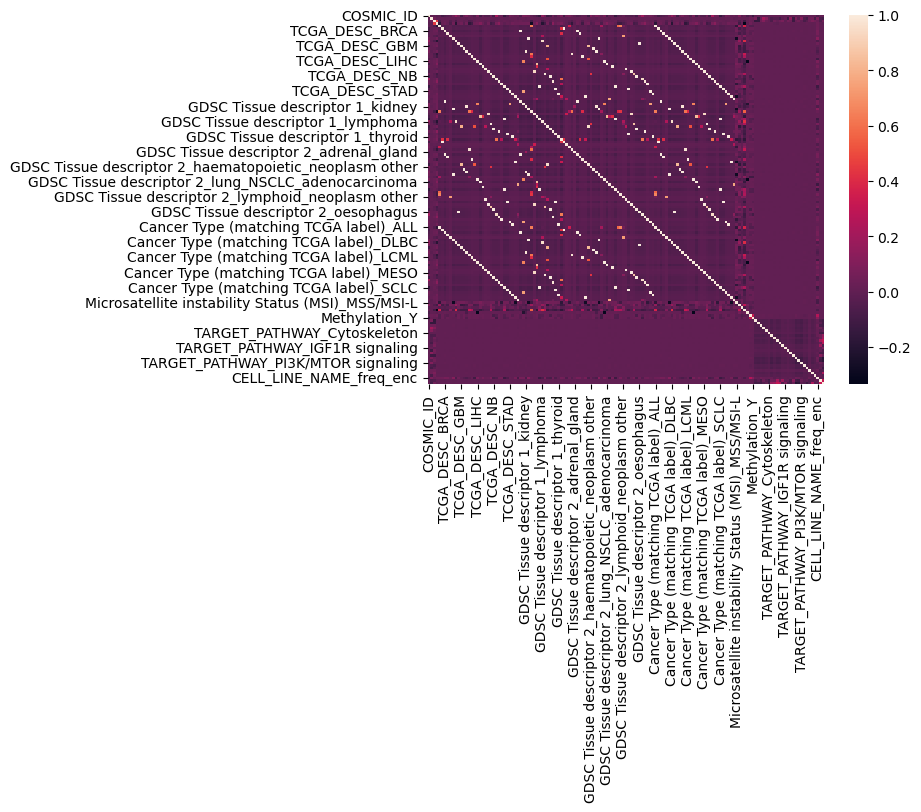

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for numerical features
corr_matrix = df_encoded.drop("LN_IC50", axis=1).corr()
sns.heatmap(corr_matrix)
plt.show()


In [ ]:
# Feature selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression

# Define target variable (adjust if your target is different)
target = "LN_IC50"
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]
features_num = 30

# (Optional) Scale the features – many feature selection methods benefit from standardized inputs.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Filter Method: SelectKBest ---
selector_filter = SelectKBest(score_func=f_regression, k=features_num)  # Adjust k as necessary
X_filter = selector_filter.fit_transform(X_scaled, y)
selected_features_filter = X.columns[selector_filter.get_support()]
print("Selected features via SelectKBest:", selected_features_filter.tolist())

# --- Wrapper Method: RFE with Linear Regression ---
model = LinearRegression()
selector_wrapper = RFE(estimator=model, n_features_to_select=features_num)  # Choose a suitable number of features
selector_wrapper.fit(X_scaled, y)
selected_features_wrapper = X.columns[selector_wrapper.get_support()]
print("Selected features via RFE:", selected_features_wrapper.tolist())


Selected features via SelectKBest: ['DRUG_ID', 'AUC', 'Z_SCORE', 'TCGA_DESC_ALL', 'TCGA_DESC_DLBC', 'TCGA_DESC_LAML', 'GDSC Tissue descriptor 1_leukemia', 'GDSC Tissue descriptor 1_lymphoma', 'GDSC Tissue descriptor 1_pancreas', 'GDSC Tissue descriptor 2_acute_myeloid_leukaemia', 'GDSC Tissue descriptor 2_pancreas', 'Cancer Type (matching TCGA label)_ALL', 'Cancer Type (matching TCGA label)_DLBC', 'Cancer Type (matching TCGA label)_LAML', 'Cancer Type (matching TCGA label)_PAAD', 'Growth Properties_Suspension', 'TARGET_PATHWAY_Apoptosis regulation', 'TARGET_PATHWAY_Cell cycle', 'TARGET_PATHWAY_Chromatin histone methylation', 'TARGET_PATHWAY_DNA replication', 'TARGET_PATHWAY_Genome integrity', 'TARGET_PATHWAY_Hormone-related', 'TARGET_PATHWAY_JNK and p38 signaling', 'TARGET_PATHWAY_Metabolism', 'TARGET_PATHWAY_Mitosis', 'TARGET_PATHWAY_Other', 'TARGET_PATHWAY_Protein stability and degradation', 'TARGET_PATHWAY_WNT signaling', 'TARGET_PATHWAY_p53 pathway', 'DRUG_NAME_freq_enc']


## Only GDSC

In [ ]:
gdsc_df_clean = gdsc_dataset.dropna(subset=['TARGET'])

gdsc_df_clean['Cancer Type (matching TCGA label)'].fillna(gdsc_df_clean['Cancer Type (matching TCGA label)'].mode()[0], inplace=True)
gdsc_df_clean['Microsatellite instability Status (MSI)'].fillna(gdsc_df_clean['Microsatellite instability Status (MSI)'].mode()[0], inplace=True)

# Cap outliers in LN_IC50 using IQR method (Winsorization)
Q1 = gdsc_df_clean['LN_IC50'].quantile(0.25)
Q3 = gdsc_df_clean['LN_IC50'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

gdsc_df_clean['LN_IC50'] = gdsc_df_clean['LN_IC50'].clip(lower=lower_bound, upper=upper_bound)

/var/folders/r2/rb9xm5r1631c_cy3m9_8xwk80000gn/T/ipykernel_60609/2826124137.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdsc_df_clean['Cancer Type (matching TCGA label)'].fillna(gdsc_df_clean['Cancer Type (matching TCGA label)'].mode()[0], inplace=True)
/var/folders/r2/rb9xm5r1631c_cy3m9_8xwk80000gn/T/ipykernel_60609/2826124137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [69]:
# Print out the columns and their data types
print("Columns and their data types:")
print(gdsc_df_clean.dtypes)

Columns and their data types:
COSMIC_ID                                    int64
CELL_LINE_NAME                              object
TCGA_DESC                                   object
DRUG_ID                                      int64
DRUG_NAME                                   object
LN_IC50                                    float64
AUC                                        float64
Z_SCORE                                    float64
GDSC Tissue descriptor 1                    object
GDSC Tissue descriptor 2                    object
Cancer Type (matching TCGA label)           object
Microsatellite instability Status (MSI)     object
Screen Medium                               object
Growth Properties                           object
CNA                                         object
Gene Expression                             object
Methylation                                 object
TARGET                                      object
TARGET_PATHWAY                              object
d

In [66]:
# print the number of unique values in each non-numeric column
non_numeric_cols = gdsc_df_clean.select_dtypes(exclude=[np.number]).columns
print("Unique values in non-numeric columns:")
for col in non_numeric_cols:
    unique_count = gdsc_df_clean[col].nunique()
    print(f"{col}: {unique_count} unique values")

Unique values in non-numeric columns:
CELL_LINE_NAME: 969 unique values
TCGA_DESC: 32 unique values
DRUG_NAME: 249 unique values
GDSC Tissue descriptor 1: 19 unique values
GDSC Tissue descriptor 2: 54 unique values
Cancer Type (matching TCGA label): 31 unique values
Microsatellite instability Status (MSI): 2 unique values
Screen Medium: 2 unique values
Growth Properties: 3 unique values
CNA: 2 unique values
Gene Expression: 2 unique values
Methylation: 2 unique values
TARGET: 185 unique values
TARGET_PATHWAY: 24 unique values


## Baseline test

In [ ]:
"""
Define exluded columns:
Target variable: 'LN_IC50'
Highly related values: 'AUC', 'Z_SCORE'
ID: 'Z_SCORE', 'DRUG_ID'
Too many unique values: 'DRUG_NAME', 'CELL_LINE_NAME'
"""
excluded_columns = ['LN_IC50', 'AUC', 'Z_SCORE', 'DRUG_ID', 'COSMIC_ID', 'DRUG_NAME', 'CELL_LINE_NAME']

MSE of the model: 2.48
R² of the model: 0.70


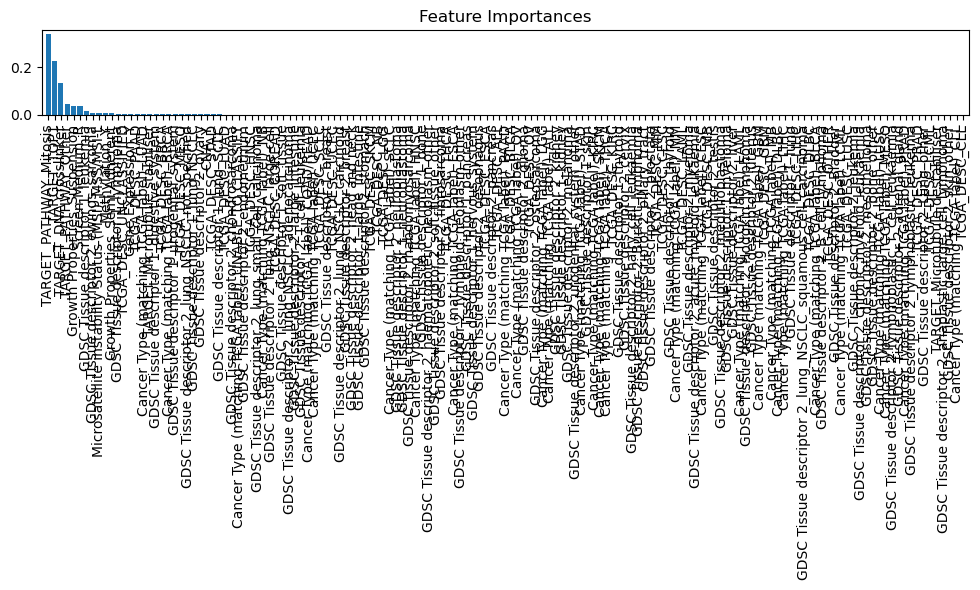

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Assume 'tmp' is your DataFrame that has already been preprocessed and includes both numeric and categorical features.
tmp = gdsc_df_clean.copy()
# Using First 3000 rows for the example
tmp = tmp.iloc[:5000, :]
# Features and target
X = tmp.drop(excluded_columns, axis=1)  # Dropping IDs
y = tmp['LN_IC50']

# One-hot encode remaining categorical features
X = pd.get_dummies(X, drop_first=True)

# # Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For this example, define a base learner as a Random Forest Regressor.
base_learner = RandomForestRegressor(random_state=42)

# Train the base learner on the training data.
base_learner.fit(X_train, y_train)

# Evaluate the model on the test set.
y_pred = base_learner.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE of the model: {mse:.2f}')
print(f'R² of the model: {r2:.2f}')

# Visualize the feature importance provided by the base learner.
importances = base_learner.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order.
sorted_features = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), sorted_features, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


In [72]:
sorted_features

Index(['TARGET_PATHWAY_Mitosis', 'TARGET_TOP1', 'TARGET_DNA crosslinker',
       'TARGET_PATHWAY_Other', 'Growth Properties_Suspension',
       'Screen Medium_R', 'GDSC Tissue descriptor 1_leukemia',
       'GDSC Tissue descriptor 2_ewings_sarcoma',
       'Microsatellite instability Status (MSI)_MSS/MSI-L', 'Methylation_Y',
       ...
       'Cancer Type (matching TCGA label)_PRAD',
       'GDSC Tissue descriptor 2_lymphoblastic_leukemia', 'TCGA_DESC_PRAD',
       'GDSC Tissue descriptor 2_Lung_other', 'TCGA_DESC_LCML',
       'TARGET_Microtubule destabiliser',
       'GDSC Tissue descriptor 2_anaplastic_large_cell_lymphoma',
       'GDSC Tissue descriptor 2_skin_other',
       'Cancer Type (matching TCGA label)_CLL', 'TCGA_DESC_CLL'],
      dtype='object', length=145)